This is a sample example of using 'EDWav' method to select diffuse waves by evaluating seismic waveform segment data with sliding window.

In [6]:
import EDWav
import obspy
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# read test wavefrom data by obspy
st=obspy.read('Demo_data/*.sac.new') # There are 5 "*.sac.new" files in the folder "Demo_data".

# using obspy for bandpass filtering
st=st.filter('bandpass',freqmin=0.03,freqmax=0.5, corners=4, zerophase=True)

# Specify the waveform to perform the selection operation
starttime=obspy.UTCDateTime(2011,7,13,0,0,0)
endtime=obspy.UTCDateTime(2011,7,14,0,0,0)
st=st.slice(starttime=starttime, endtime=endtime)

# set the parameters for sliding evaluation
# -Sampling rate: FS.
# -Frequency band range for analysis: FB.
# -Frequency resolution: FR.
# -The length of the sliding window: NW. NW represents the length of the sliding window is NW times the length of the small window. The length of the small window is defined by "len_of_win" in the "evaluate" function and is regulated by "FR" and "FB". Generally, the length of a sliding window can be consistent with the length of subsequent cross-correlation operations.
# -The movement interval of the sliding window: DW. DW represents the movement interval of the sliding window is DW times the length of the small window.
FS=st[0].stats.sampling_rate 
FB=[0.03,0.5]
FR=47
NW=6
DW=6  # DW=NW means no overlap between two adjacent sliding windows

# begin to evaluate the waveform data with sliding window
P=np.zeros((1728000,len(st)))  # P is to store the diffuseness proxy value of the waveform data. 1728000 is the length of the waveform data. 
waveform=np.zeros((1728000,len(st)))
t1=time.time()
for i in range(len(st)):
    waveform[:,i]=st[i].data[0:1728000]  # store the waveform data
    proxy, stats = EDWav.EDWav.evaluate_sliding(waveform[:,i], FS=FS, FB=FB, FR=FR, NW=NW, DW=DW)
    P[:,i]=proxy[0:1728000]              # store the diffuseness proxy
t2=time.time() 
print('Executed: ',t2-t1,' s.')
print('The length of the small window is ',stats['len_of_win']/FS,' s.')
print('The length of the sliding window is ',NW*stats['len_of_win']/FS,' s.')

# Now, set a threshold to select the diffuse waves
# We can use the MAD (median absolute deviation) method to determine the threshold. The threshold is calculated by: threshold=3*MAD+median
# A threshold can be calculated for each waveform data or a uniform threshold can be calculated for all waveform data.
# Here, we calculate a threshold for each waveform data.
threshold=np.zeros(len(st))
P_selected=np.zeros((1728000,len(st)))
waveform_selected=np.zeros((1728000,len(st)))
for i in range(len(st)):
    # We can operate on the P value or the logarithmic P value, which depends on your data
    threshold[i]=3*np.nanmedian(np.abs(np.log(P[:,i])-np.nanmedian(np.log(P[:,i]))))+np.nanmedian(np.log(P[:,i]))

    # select the diffuse waves, which are the waveform data with P value less than the threshold
    P_selected[:,i]=np.log(P[:,i])*(np.log(P[:,i])<=threshold[i])
    P_selected[P_selected[:,i]==0,i]=np.nan
    waveform_selected[:,i]=waveform[:,i]*np.sign(np.abs(P_selected[:,i]))

Executed:  1.646815538406372  s.
The length of the small window is  100.0  s.
The length of the sliding window is  600.0  s.


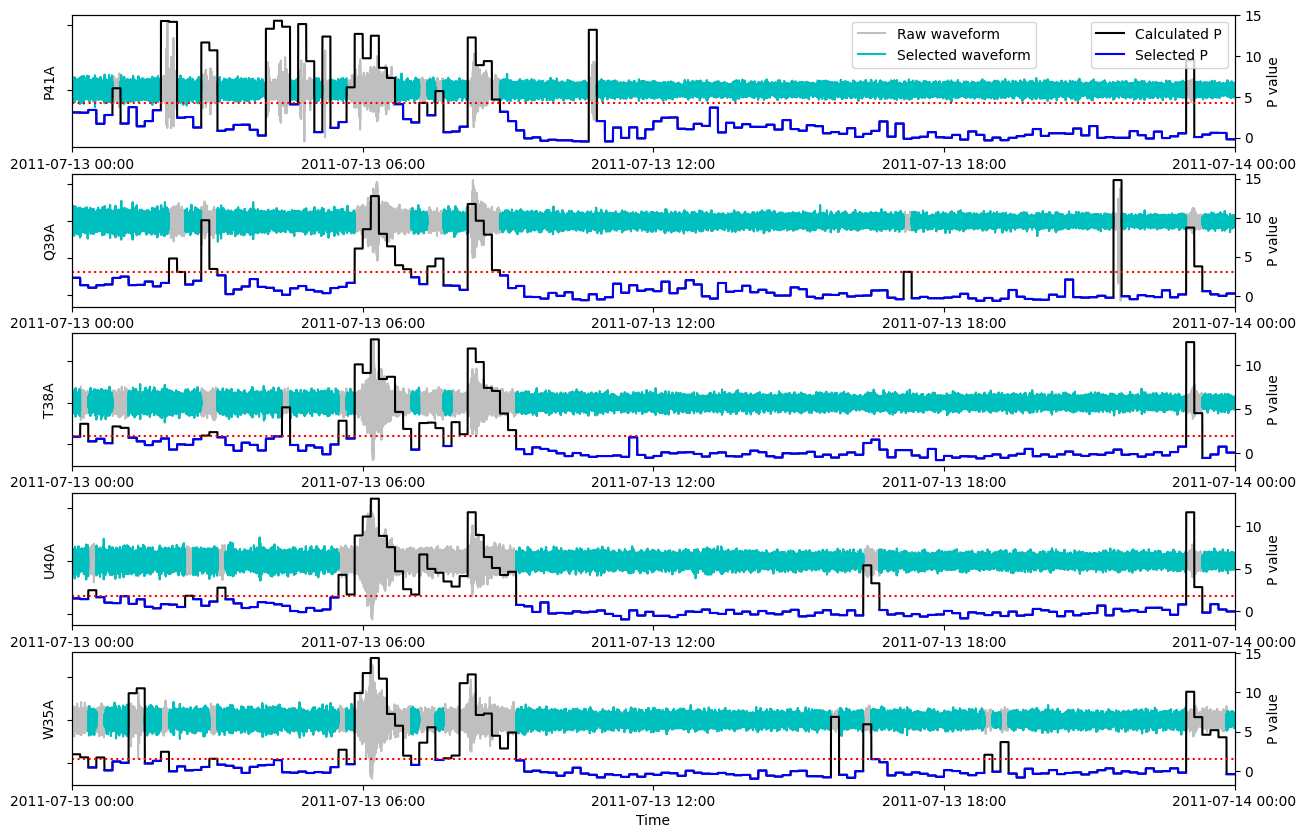

In [7]:
# plot the selected waveform data
times=[starttime.datetime + datetime.timedelta(seconds=i/FS) for i in range(1728000)]
fig, ax1 = plt.subplots(5,1,figsize=(15,10))  
step=20  # plot every 20 points to speed up
for i in range(len(st)):
    ax2 = ax1[i].twinx()  

    ax1[i].plot(times[0:-1:step],waveform[0:-1:step,i],color=[0.75,0.75,0.75])
    ax1[i].plot(times[0:-1:step],waveform_selected[0:-1:step,i],color='c')
    ax2.plot(times[0:-1:step],np.log(P[0:-1:step,i]),'k')
    ax2.plot(times[0:-1:step],P_selected[0:-1:step,i],'b')
    ax2.plot([starttime,endtime],[threshold[i],threshold[i]],'r:')

    ax1[i].set_yticklabels([])
    ax1[i].set_ylabel(st[i].stats.station)
    ax2.set_ylabel('P value')

    if i==0:
        ax1[0].legend(['Raw waveform', 'Selected waveform'], loc='upper center', bbox_to_anchor=(0.75, 1))
        ax2.legend(['Calculated P','Selected P'], loc='upper right')

    plt.xlim(starttime.datetime, endtime.datetime)
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

ax1[i].set_xlabel('Time')
plt.show()


The benefits of waveform selection are compared by cross-correlation of these five stations

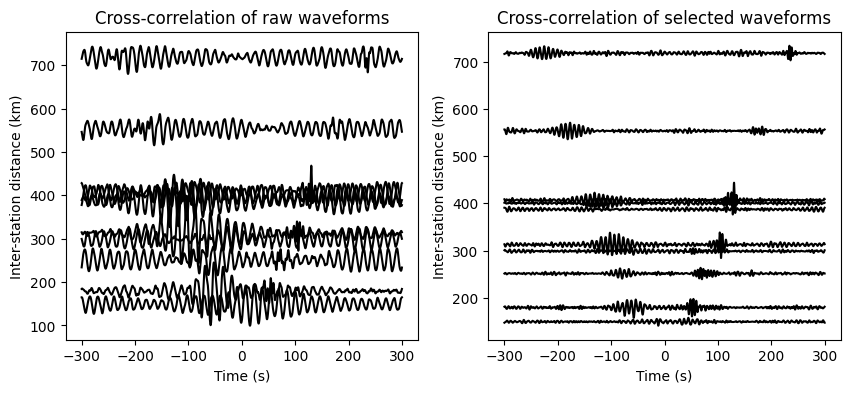

In [ ]:
from obspy.geodetics import gps2dist_azimuth

# define a simple function to calculate the cross-correlation in frequency domain
def cross_correlation(wave,RID):
    wave=np.fft.rfft(wave,axis=0)
    cc=np.fft.ifftshift(np.fft.irfft(np.conj(wave[:,RID[:,0]])*wave[:,RID[:,1]], axis=0),axes=0)
    cs=np.sign(np.sum(np.abs(cc), axis=0))
    return cc, cs

# the location of the five stations
lon=[-91.061897,-92.975899,-94.292999,-92.8535,-96.874496,]
lat=[39.674999,39.045502,37.0354,36.3563,35.152699]

# the inter-station distance
R=[]
RID=[]
for i in range(0,len(st)-1):
    for j in range(i+1,len(st)):
        dist = gps2dist_azimuth(lat[i], lon[i], lat[j], lon[j])
        R.append(dist[0]/1000)  # km
        RID.append([i,j])
RID=np.array(RID)

# the number of sliding windows in the waveform data
num_of_sld=stats['num_of_sld']

# calculate the cross-correlation of the raw waveform data
CC1=0
CS1=0
for i in range(num_of_sld):
    wave=waveform[i*NW*stats['len_of_win']:(i+1)*NW*stats['len_of_win'],:]
    cc, cs =cross_correlation(wave,RID)
    CC1=CC1+cc
    CS1=CS1+cs

# calculate the cross-correlation of the selected waveform data
CC2=0
CS2=0
for i in range(num_of_sld):
    wave=waveform_selected[i*NW*stats['len_of_win']:(i+1)*NW*stats['len_of_win'],:]
    wave[np.isnan(wave)]=0
    cc, cs =cross_correlation(wave,RID)
    CC2=CC2+cc
    CS2=CS2+cs

# plot the cross-correlation
fig, ax = plt.subplots(1,2,figsize=(10,4))  
for i in range(len(R)):
    ax[0].plot(np.arange(-NW/2*stats['len_of_win'],NW/2*stats['len_of_win'],1)/FS, 2e12*CC1[:,i]/CS1[i]+R[i],'k')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Inter-station distance (km)')
ax[0].set_title('Cross-correlation of raw waveforms')

for i in range(len(R)):
    ax[1].plot(np.arange(-NW/2*stats['len_of_win'],NW/2*stats['len_of_win'],1)/FS, 2e12*CC2[:,i]/CS2[i]+R[i],'k')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Inter-station distance (km)')
ax[1].set_title('Cross-correlation of selected waveforms')

plt.show()

# From the camparison of the cross-correlation of the raw waveform data and the selected waveform data, 
# we can see that the selected waveform data has clearer surface wave propagation characteristics and higher signal-to-noise ratio.
# This indicates that the selected waveform data are more suitable for surface wave cross-correlation analysis.
#
# This case uses waveform data of one day. The empirical Green's function of surface wave with more reliable phase and amplitude can be obtained by stacking the data of more days.